# Imports and Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

# Parameters for MC simulation

In [2]:
S0 = 100      # initial stock price
K = 100       # strike price
sigma = 0.15  # volatility
r = 0.03      # risk-free rate
mu = r        # drift set to risk-free rate for risk-neutral measure (previously 0.05)
M = 1         # maturity in years
T = 50       # number of time steps
N_MC = 10000  # number of paths
degree = 3    # degree of polynomial basis functions
delta_t = M / T                # time interval
gamma = np.exp(-r * delta_t)  # discount factor

# Black-Scholes put price for comparison

In [3]:
def bs_put(t, S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * (T-t)) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    return K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Basis functions (polynomials up to specified degree)
* Defines basis_functions(X, degree):
  - Creates a matrix of polynomial terms: columns are X^0, X^1, ..., X^degree.
* Purpose: These are used in least-squares regression to approximate continuation values in the LSM algorithm (a key part of pricing American options).

In [4]:
def basis_functions(X, degree):
    return np.column_stack([X**k for k in range(degree + 1)])

# Simulate stock price paths
* Generates Z: A matrix of standard normal random variables (size N_MC x T) for Brownian motion increments.
* Initializes S: A matrix (size N_MC x (T+1)) for stock prices, starting with S[:, 0] = S0.
* Simulates paths using a loop over time steps:
  * S[:, t+1] = S[:, t] * exp((mu - 0.5*sigma^2)*delta_t + sigma*sqrt(delta_t)*Z[:, t]).
* Purpose: This generates discrete-time geometric Brownian motion paths under the risk-neutral measure, mimicking stock price evolution.

In [5]:
np.random.seed(42)
Z = np.random.normal(0, 1, (N_MC, T))
S = np.zeros((N_MC, T + 1))
S[:, 0] = S0
for t in range(T):
    S[:, t + 1] = S[:, t] * np.exp((mu - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * Z[:, t])

# Compute state variable X_t
* Purpose: X_t is a transformed state variable (log-stock price adjusted for drift). It's used as the input for basis functions in regression, helping approximate option values conditional on the state.

In [6]:
X = - (mu - 0.5 * sigma**2) * np.arange(T + 1) * delta_t + np.log(S)

# Compute payoff (for a put option)

In [7]:
payoff = np.maximum(K - S, 0)

# LSM for American option pricing
* Initializes V: Option value matrix, same size as payoff. Sets V[:, T] = payoff[:, T] (at maturity, value equals payoff).
* Initializes exercise: A boolean matrix tracking early exercise decisions.
* Backward induction loop (from t = T-1 to 0):
  * Identifies in-the-money (ITM) paths where payoff[:, t] > 0.
  * For ITM paths:
    * Fits a regression: Basis functions of stock price (S[itm, t]) against discounted next-period values (gamma * V[itm, t+1]).
    * Computes continuation value C_itm as the predicted value from the regression.
    * Decides to exercise if payoff > C_itm.
    * Sets V[itm, t] to payoff if exercised, else discounted next value.
  * For out-of-the-money paths: V[\~itm, t] = gamma * V[\~itm, t+1] (always continue).
* Purpose: This approximates the optimal exercise boundary for the American option using regression to estimate continuation values, allowing early exercise when beneficial.

In [8]:
V = np.zeros_like(payoff)
V[:, T] = payoff[:, T]
exercise = np.zeros((N_MC, T), dtype=bool)

for t in range(T - 1, -1, -1):
    itm = payoff[:, t] > 0
    if np.any(itm):
        X_itm = basis_functions(S[itm, t], degree)
        Y_itm = gamma * V[itm, t + 1]
        reg = np.linalg.lstsq(X_itm, Y_itm, rcond=None)[0]
        C_itm = np.dot(X_itm, reg)  # continuation value
        exercise_itm = payoff[itm, t] > C_itm
        exercise[itm, t] = exercise_itm
        V[itm, t] = np.where(exercise_itm, payoff[itm, t], gamma * V[itm, t + 1])
    V[~itm, t] = gamma * V[~itm, t + 1]

# Computing the American Option Price

In [9]:
option_price = np.mean(V[:, 0])

# Compute optimal hedge a_t using basis functions
* Initializes hedge: Matrix for hedge ratios (delta) at each time/path.
* Initializes portfolio and cash: Track portfolio value and cash position over time, starting with option_price.

In [10]:
hedge = np.zeros((N_MC, T))
portfolio = np.zeros((N_MC, T + 1))
portfolio[:, 0] = option_price  # Initial portfolio value
cash = np.zeros((N_MC, T + 1))
cash[:, 0] = option_price  # Initially all in cash

Loop over time steps t from 0 to T-1:
* Identifies "alive" paths (not yet exercised).
* For alive paths:
   * Regresses basis functions of X[alive, t] against discounted next values to approximate continuation.
   * Computes hedge a_t as the derivative dV/dS: Sum of regression coefficients times polynomial derivatives, divided by S (chain rule: dV/dX * dX/dS = dV/dX / S).
   * Updates cash: portfolio - hedge * S.
   * Updates next portfolio: hedge * next_S + cash * exp(r*delta_t) (rebalanced position).
* Purpose: This builds a dynamic hedging strategy (replication portfolio) that aims to mimic the option's payoff by holding stock and cash, adjusting based on the estimated delta hedge.

In [11]:
for t in range(T):
    alive = ~np.any(exercise[:, :t + 1], axis=1)  # Paths not yet exercised
    if np.any(alive):
        # Approximate continuation value at t+1
        X_alive = basis_functions(X[alive, t], degree)
        Y_alive = gamma * V[alive, t + 1]
        reg = np.linalg.lstsq(X_alive, Y_alive, rcond=None)[0]
        
        # Compute hedge a_t as derivative dV_t/dS_t   
        # V_t ≈ sum(w_k * X_t^k), dV_t/dX_t = sum(w_k * k * X_t^(k-1)), dX_t/dS_t = 1/S_t
        dV_dX = sum(reg[k] * k * X[alive, t]**(k - 1) for k in range(1, degree + 1))
        a_t = dV_dX / S[alive, t]
        hedge[alive, t] = a_t
        
        # Update portfolio and cash
        cash[alive, t] = portfolio[alive, t] - hedge[alive, t] * S[alive, t]
        portfolio[alive, t + 1] = hedge[alive, t] * S[alive, t + 1] + cash[alive, t] * np.exp(r * delta_t)
    else:
        portfolio[alive, t + 1] = 0  # If all exercised, portfolio value is 0

# Computing Portfolio Error at Exercise Time
* Finds exercise times per path (or maturity if never exercised).
* Computes portfolio_error: Difference between portfolio value and actual payoff at exercise time.
* Purpose: Evaluates how well the replication portfolio matches the option's payoff (hedging error).

In [12]:
exercise_times = np.argmax(exercise, axis=1)
exercise_times[~np.any(exercise, axis=1)] = T  # If never exercised, set to T
portfolio_error = portfolio[np.arange(N_MC), exercise_times] - payoff[np.arange(N_MC), exercise_times]
initial_delta = hedge[:, 1].mean()

# Results

In [13]:
print(f"American Option Price (Replication Portfolio Value at t=0): {option_price:.4f}")
print(f"Initial Delta at t=0: {initial_delta:.4f}")
print(f"Mean Portfolio Error at Exercise: {np.mean(portfolio_error):.4f}")
print(f"Standard Deviation of Portfolio Error: {np.std(portfolio_error):.4f}")
bs_price = bs_put(0, S0, K, r, sigma, M)
print(f"Black-Scholes European Put Price (for reference): {bs_price:.4f}")

American Option Price (Replication Portfolio Value at t=0): 4.8266
Initial Delta at t=0: -0.4367
Mean Portfolio Error at Exercise: 0.0684
Standard Deviation of Portfolio Error: 1.5279
Black-Scholes European Put Price (for reference): 4.5296


# Plot a few stock price paths and portfolio values

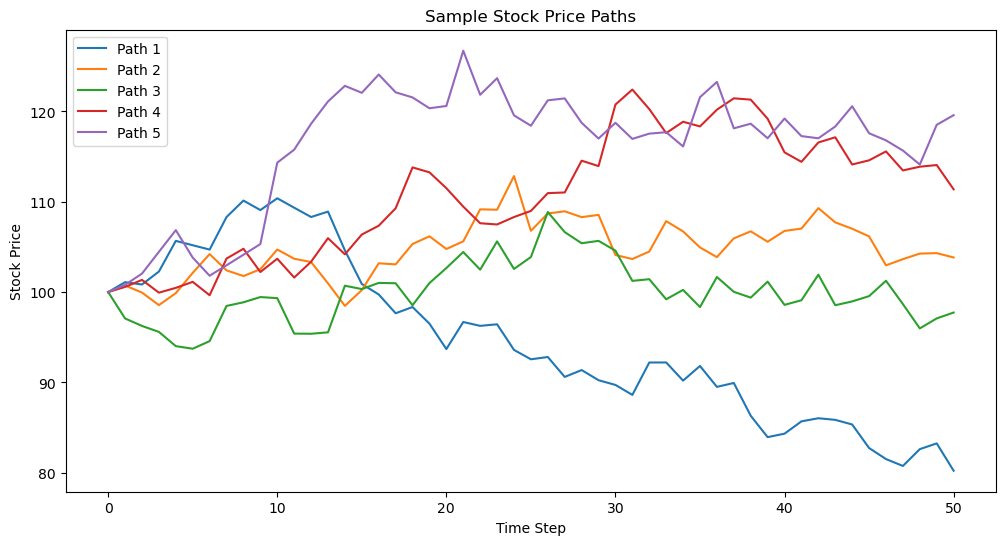

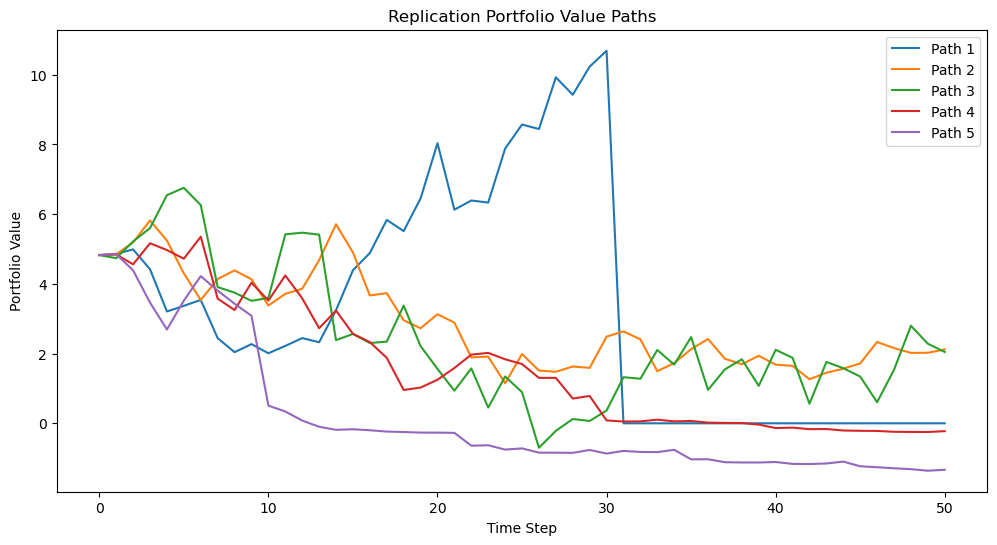

In [14]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(S[i], label=f"Path {i+1}")
plt.title("Sample Stock Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.legend()
plt.savefig("Sample Stock Price Paths.png")
plt.show()


plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(portfolio[i], label=f"Path {i+1}")
plt.title("Replication Portfolio Value Paths")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.savefig("Replication Portfolio Value Paths.png")
plt.show()

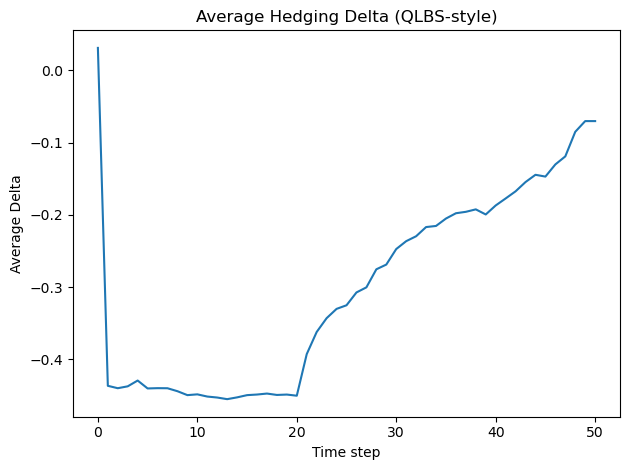

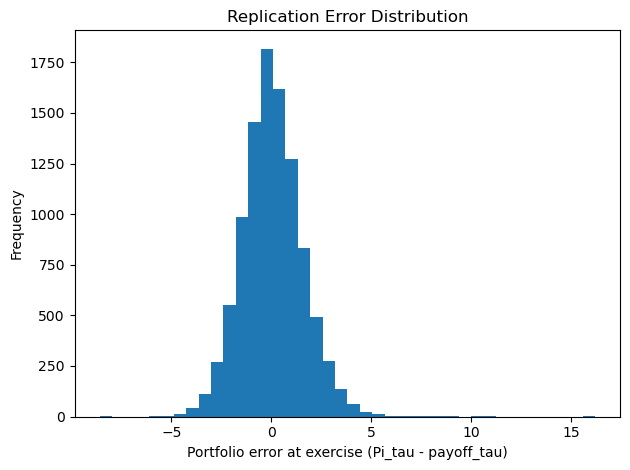

In [21]:
avg_delta = hedge.mean(axis=0)
y_vals = np.append(avg_delta, avg_delta[-1])

plt.figure()
plt.plot(np.arange(T+1), y_vals)
plt.xlabel('Time step'); plt.ylabel('Average Delta'); plt.title('Average Hedging Delta (QLBS-style)'); plt.tight_layout()
plt.savefig("Average Hedging Delta (QLBS-style).png")
plt.show()

plt.figure()
plt.hist(portfolio_error, bins=40)
plt.xlabel('Portfolio error at exercise (Pi_tau - payoff_tau)'); plt.ylabel('Frequency'); plt.title('Replication Error Distribution'); plt.tight_layout()
plt.savefig("Replication Error Distribution.png")
plt.show()